# Image Classification with CNNs



## Introduction

In this assignment, we are going to build, train and validate **convolutional neural networks** (ConvNets).
For this purpose, we will use data from the publicly available CIFAR10 dataset.
CIFAR10 is a dataset commonly used in the community of computer vision and machine learning to benchmark new algorithms and network architectures.

CIFAR10 is a dataset that contains (small) RGB images of 32x32 px of ten different classes:

    * airplane
    * automobile
    * bird
    * cat
    * deer
    * dog
    * frog
    * horse
    * ship
    * truck
More details can be found at this link: https://www.cs.toronto.edu/~kriz/cifar.html

Based on an overview found on this website: https://paperswithcode.com/sota/image-classification-on-cifar-10, the current state-of-the-art result on this dataset has reached an accuracy of 99.7%.

In this assignment, you will probably reach an accuracy between 60% and 70%, which is perfectly fine!

## Data
We will train our ConvNet with images from CIFAR10, a dataset of 60,000 colour images of 32x32 pixels in 10 classes. The downloaded training samples come split into 5 batches of 10,000 samples each, which is useful to do cross-validation for example. In this assignment, you will have to decide how to best split the dataset into training and validation sets. A separate test set is provided in CIFAR10, which is the same set used by other researchers to benchmark their methods.

## Tasks
We define 10 tasks in this assignment.
Although 10 tasks sound like a lot of work, you will see that they are highly repetitive (meaning, you will do a lot of copy-paste across cells in the notebook),
Like we mentioned in the lecture this week, given the experience you have gained by defining datasets and training neural networks, training convolutional neural networks is just a natural step towards using a different architectures (and some additional tricks and tools).

---

The task that we propose are the following:

### Task 1. Split data and build convolutional networks
In this task, you will first define your training and validation set, then you will build the architecture of convolutional networks.

### Task 2. Train convolutional networks
In this task, you will train your first model using CIFAR10, apply the trained model to the test set. In order to define training functions and parameteres, you can reuse a lot of code developed last week.

### Task 3. Add dropout layer(s)
In this task, you will modify the architecture of your network by adding dropout, which is implemented in Keras in the form of a layer. After that, you will repeat the training procedure and compare the results with the ones of the *plain* network.

### Task 4. Add batch normalization
In this task, you will do something similar to task 3, but now adding batch normalization.
You will repeat the experiment and compare the performance with previous architectures.

### Task 5. Try different initialization strategies
We have seen that at least a couple of initilization strategies are known in the literature for (convolutional) neural networks.
Several strategies are implemented in the Keras library.
Try some of them and report the results.

### Task 6. Try different nonlinearities
The same for nonlinearities, we have seen that ```ReLU``` is some kind of default choice for ConvNets, but other strategies exists. Do experiments, report the results and compare with previous approaches.

### Task 7. Add L2 regularization
Modify the loss function to use L2 regularization.
Again, run experiments and report results.

### Task 8. Add data augmentation
Think of possible ways you can augment the (training) data.
You can build a new (bigger) training set, or implement some kind of data augmentation *on-the-fly*, where some patches in the mini-batch are randomly selected and augmented with a (random) operation. Think of transformations that make sense in the context of classification of natural images.

### Task 9. Try a different architecture
You can try to improve the performance by modifying the architecture, using more layers, or wider layers (same number of layers but more filters, which means more parameters). Use all the tools you have investigated so far, the optimal combination of the options you have tried in previous tasks. The goal is to get high accuracy on the validation (and therefore on the test) set!

### Task 10. Monitor the training procedure
Finally, implement some tools to monitor the training procedure.
Examples are the analysis of statistics of activations, or visualizing the filters learned.
If done during training, visualizing filter will also nicely show how the network refines random parameters to come up with meaningful filters (especially in the first layer).

---


In this notebook we provide some parts of code implemented.
Some other parts are not implemented, but we define the variables that will be used in functions, to help you in the development of the assignment.

## Let's get started

In [1]:
pip install keras tensorflow tqdm

In [2]:
# import libraries
import numpy as np
import os #operation system
import pickle
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 5)
from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import models, layers, activations
from keras.models import Model
from PIL import Image, ImageFilter
from keras import regularizers

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17503037198453664908
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7386304034992501625
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Get to know your data: Load data and define datasets

CIFAR10 contains 5 batches that can be used for training/validation, and one batch that consists of the test set.
In order to train your network, you will have to define a training set and a validation set. Do not use the test set as training data, and do not use any knowledge on the labels of the test set (being a publicly available dataset, we cannot avoid exposing the labels of the test set).


Think of the best way to split data into training and validation set. Note that the format that layers in convolutional networks like (at least in the Keras/Tensorflow libraries that we are using), is as follows:

    (n_samples, rows, cols, n_channels)

This means that each training (but also validation and test) sample needs to have four dimensions. This kind of structure (multi-dimensional array), is called a **tensor**. In practice, this format is also convenient because the first index of the tensor refers to the sample itself, so we can use:

    tensor[i]
    
to extract the i-th example.

During training, several samples will be used to update the parameters of a network. In the case of CIFAR10, if we use M samples per mini-batch, the shape of the mini-batch data is:

    (M, 32, 32, 3)

Make sure data is organized in this way, for the training, validation and test datasets.

### Download CIFAR10 data
The following cell will download the 5 batches of the CIFAR10 training dataset as well as the test set to your disk and load it in memory.

In [3]:
from tensorflow.keras.utils import get_file
origin_url = 'https://surfdrive.surf.nl/files/index.php/s/{key}/download'

# Dictionary mapping file names to download keys
files = {
    'cifar10-batch-1': '4Nee36XgbYjp3N6',
    'cifar10-batch-2': 'LVx85dLceKI5toF',
    'cifar10-batch-3': '4FoFmeKyXa5sYr0',
    'cifar10-batch-4': 'a4o2RatC0Fa3Exb',
    'cifar10-batch-5': 'eqBJRWdkRGk025k',
    'cifar10-test': 'nEf9Z4eg7iGmWGU'
}

# Download files to local drive (only downloads the files once)
local_files = [{'name': n,
                'file': get_file(n, origin=origin_url.format(key=k))} for n,
                k in files.items()]

# Load all batches in memory
batches = {lf['name']: pickle.load(open(lf['file'], 'rb'),
                                   encoding='latin1') for lf in local_files}

# Convert data to floats and reshape to correct format
# This is specific for CIFAR10
for batch in batches.values():
    # Images were originally used as (CxWxH), convert to (WxHxC)
    batch['data'] = (batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.).astype("float32")

data_size_in = (32, 32, 3)
n_classes=10

31035704/31035704 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
31035320/31035320 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
31035999/31035999 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
31035696/31035696 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
31035623/31035623 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
31035526/31035526 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The CIFAR dataset is now loaded in memory in the form of a Python dictionary. To get to know your data, check what are the keys of such a dictionary:

In [4]:
print(batches.keys())

dict_keys(['cifar10-batch-1', 'cifar10-batch-2', 'cifar10-batch-3', 'cifar10-batch-4', 'cifar10-batch-5', 'cifar10-test'])


Before you define your datasets, it is useful to check the distribution of labels across batches of CIFAR10, in case some batches have skewed distributions of labels.
In order to do that, you can use visualize the histogram of labels using the function ```hist()``` of the matplotlib library:

    plt.hist()

Text(0.5, 1.0, 'batch_5')

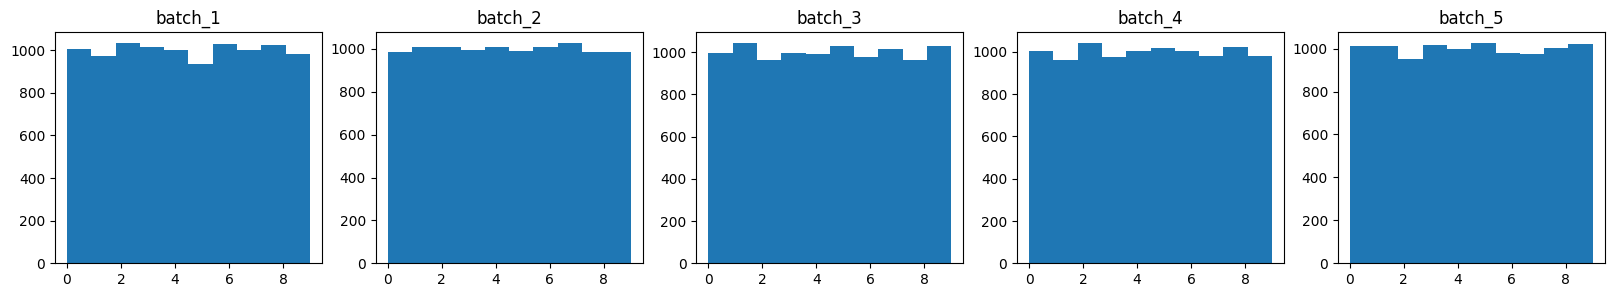

In [5]:
fig = plt.figure(figsize=(20, 3))
plt.subplot(1,5,1); plt.hist(batches['cifar10-batch-1']['labels']); plt.title('batch_1')
plt.subplot(1,5,2); plt.hist(batches['cifar10-batch-2']['labels']); plt.title('batch_2')
plt.subplot(1,5,3); plt.hist(batches['cifar10-batch-3']['labels']); plt.title('batch_3')
plt.subplot(1,5,4); plt.hist(batches['cifar10-batch-4']['labels']); plt.title('batch_4')
plt.subplot(1,5,5); plt.hist(batches['cifar10-batch-5']['labels']); plt.title('batch_5')

#### Question
Do you think that you have to organize batches in a specific way in order to make a training and a validation set, and would this affect the performance of your network significantly?

*Your answer here.*

As it is clear from histograms, the distribution is balanced (not skewed). The margins between classes, in each batch, look acceptable, so we would not face any problem related to imbalanced data.


Implement now a function ```load_data``` that builds and returns the training and validation datasets. You will be using this function in your experiments later.

In [6]:
# define training, validation and test sets
def load_data():

    # make training set
    train_x = np.zeros((40000, 32, 32, 3)).astype("float32")
    train_x[0:10000] = batches['cifar10-batch-1']['data']
    train_x[10000:20000] = batches['cifar10-batch-2']['data']
    train_x[20000:30000] = batches['cifar10-batch-3']['data']
    train_x[30000:40000] = batches['cifar10-batch-4']['data']

    # ADD DATA TO THE VARIABLE x_train

    train_y = np.zeros((40000))
    train_y[0:10000] = batches['cifar10-batch-1']['labels']
    train_y[10000:20000] = batches['cifar10-batch-2']['labels']
    train_y[20000:30000] = batches['cifar10-batch-3']['labels']
    train_y[30000:40000] = batches['cifar10-batch-4']['labels']

    # make validation set
    val_x = batches['cifar10-batch-5']['data']
    val_y = batches['cifar10-batch-5']['labels']

    # make test set
    test_x = batches['cifar10-test']['data']

    # load labels CIFAR10
    label_to_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
                      4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

    print ("-----------------------------------------------------")
    print (label_to_names)
    print ("-----------------------------------------------------")
    print ("> shape training set tensor: {}".format(train_x.shape))
    print ("> length training labels: {}".format(len(train_y)))
    print ("-----------------------------------------------------")
    print ("> shape validation set tensor: {}".format(val_x.shape))
    print ("> length training labels: {}".format(len(val_y)))
    print ("-----------------------------------------------------")
    print ("> shape test set tensor: {}".format(test_x.shape))

    return train_x, train_y, val_x, val_y, test_x

Note that Keras also provides the option to directly import popular datasets (see https://www.tensorflow.org/api_docs/python/tf/keras/datasets), which is helpful to quickly set-up your future experiments.

# Task 1: build a simple convolutional network

In this task you create the definition of your convolutional network. If you want you can check out the **functional API** of Keras; this API enables you to make more advanced models and is more flexible to use. A guide can be found here: https://www.tensorflow.org/api_docs/python/tf/keras

Example of sequential API:
```python
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(32, input_dim=784), activation='relu')
model.add(layers.Dense(32, activation='relu')
model.add(layers.Dense(10, activation='softmax'))

model.compile(...)
```

Example of same model using the functional API (**recommended**):

```python
from keras import models, layers

inputs = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(...)
```

The functional API can look a bit more complex at start in comparision to the sequential API. However, it gives you access to each individual layer and lets you more easily build up your network. The only difference between the two APIs is the way you build up your network, all other parts (training, applying a network, etc.) are the same.

### Network
Define your network builder function.
We build a convolutional network that contains:

1. input layer
2. convolutional layer
3. max pooling layer
4. convolutional layer
5. max pooling layer
6. fully-connected layer(s)
7. soft-max layer

### Hint

1. Select the number of convolutional and max pooling layers and choose the filter size so that the input image is shrinked to 5x5 before the fully connected layers.
2. Use at least one fully connected layer between the last convolutional layer and the output layer (which is the fully connected layer with softmax nonlinearity).
3. You can reuse the code you used last week to build a fully-connected network, just remember that this time you have to use convolutional layers!

In [7]:
# Define your network builder function. You can assume the (32, 32, 3) input size.
def build_neural_network(data_size_in, n_classes):

    # feature extraaction with CNNs
    inputs = layers.Input(shape=data_size_in)
    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(inputs)
    network_2 = layers.MaxPool2D(pool_size=(2, 2))(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_2)
    network_4 = layers.MaxPool2D(pool_size=(2, 2))(network_3)
    network_5 = layers.Flatten()(network_4)
    # Classification with MLP
    network_6 = layers.Dense(128, activation='relu')(network_5)
    prediction = layers.Dense(n_classes, activation='softmax')(network_6)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

## Loss function & Optimization Algorithm

Now that the architecture is defined, we have to specify the two other components of our learning framework, namely the loss function and the optimization algorithm.

Once you have defined these two components, you will have to **compile** the network that you have defined with the function ```build_neural_network```, using the function ```network.compile()```.

The ```network.compile()``` function requires the following input parameters:
1. loss function -> the loss function
2. optimizer -> the optimization algorithm
3. metrics -> the performance parameters you want to compute

You can find information about how to use the ```compile()``` function at this page: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

### Loss
We have to define a function that, given the network, gets the predicted probability for a given input sample.
Since we are dealing with a multi-class classification problem, **categorical cross-entropy** seems a reasonable choice.

### Optimization algorithm
We also have to specify how we want to train our model. In our case, we will use "Stochastic Gradient Descent". Gradient descent algorithms need a **learning rate**, which indicates how much we step in the (opposite) direction of the gradient. We have also seen that strategy to adapt the learning rate during training are possible, but for the moment we just define a fixed learning rate. Pick a value and see what happens, you can optimize this later.

### Metrics
Since we are developing a classifier for a multi-class problem, the accuracy seems like a reasonable choice.

In the end, you need to compile your network with your settings.

In [8]:
# experimental setup
ls = 'CategoricalCrossentropy' # define the (string) loss function
lr = 0.1 # pick a value for your learning rate
sgd = keras.optimizers.SGD(learning_rate=lr) # define Stochastic Gradient Descent as the keras optimizer, which takes the learning rate as input parameter
metric = ['acc'] # define (Python) list of metrics

network = build_neural_network(data_size_in, n_classes)
network.compile(loss=ls, optimizer=sgd, metrics=metric)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,026 (1.34 MB)

 Trainable params: 350,026 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

None


### One-hot encoding

If we are using categorical cross-entropy as loss function, we need a representation of labels in the training (and later validation) data in a 'one-hot' form. This means that if we have 5 classes, the format of labels has to be the following:

* ```y_train = 1 -> [1, 0, 0, 0, 0]```
* ```y_train = 2 -> [0, 1, 0, 0, 0]```
* ```y_train = 3 -> [0, 0, 1, 0, 0]```
* ```y_train = 4 -> [0, 0, 0, 1, 0]```
* ```y_train = 5 -> [0, 0, 0, 0, 1]```

Lucky for you, Keras has implemented such a [function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical). We can use that to convert the given format into a 'one-hot' format. First, check the format of labels in your dataset, then check if the function of Keras does what it is supposed to do.

In [9]:
# Load data using the function we defined above
train_x, train_y, val_x, val_y, test_x = load_data()

train_y_one_hot = tf.keras.utils.to_categorical(train_y,
                                                num_classes=n_classes)
val_y_one_hot = tf.keras.utils.to_categorical(val_y,
                                              num_classes=n_classes)

# This should print: (40000, 10)
print('train_y_one_hot.shape: ', train_y_one_hot.shape)
# This should print: (10000, 10)
print('val_y_one_hot.shape: ', val_y_one_hot.shape)

# check number of samples per class
print (np.sum(train_y_one_hot, axis=0))
print (np.sum(val_y_one_hot, axis=0))

-----------------------------------------------------
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
-----------------------------------------------------
> shape training set tensor: (40000, 32, 32, 3)
> length training labels: 40000
-----------------------------------------------------
> shape validation set tensor: (10000, 32, 32, 3)
> length training labels: 10000
-----------------------------------------------------
> shape test set tensor: (10000, 32, 32, 3)
train_y_one_hot.shape:  (40000, 10)
val_y_one_hot.shape:  (10000, 10)
[3986. 3986. 4048. 3984. 4003. 3975. 4020. 4023. 3997. 3978.]
[1014. 1014.  952. 1016.  997. 1025.  980.  977. 1003. 1022.]


### Check validation performance before training
All the main components required to train our network have been defined now.
However, we have seen that in order to properly monitor the behaviour of a network during training, we should check the performance (the accuracy) on a separate validation set, and see if it returns something sensible.
For this purpose, you can use the function ```network.evaluate``` in Keras, and set the ```batch_size``` to a value that fits in your GPU/CPU.

In [10]:
# validate the network
scores = network.evaluate(val_x, val_y_one_hot, batch_size=None)
val_loss = scores[0]
val_acc = scores[1]
print ('Initial validation accuracy = {:.2f}%'.format(100.*val_acc))

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.1090 - loss: 2.3167
Initial validation accuracy = 10.58%


# Task 2: Train your network
Now you can define a function that does trains the convnet by updating parameters for each mini-batch. This function will have to inculde the two main steps that we implemented last week:

  1. a pass over the training set, to update the parameters
  2. a pass over the validation set, to check the performance.
  
During training/validation, you will have to store the loss and accuracy values, in order to visualize them after each epoch in a plot that shows the learning curves. This is useful to monitor the training procedure.
Note that all these steps have been implemented in the previous assignment, you can reuse a lot of that code!

During training, we will also be saving to disk the parameters of the network wich has the best performance on the validation set. This will be stored as the file ```best_model.h5``` in the direcotry ```network_dir```, which by default is the root directory of this notebook.

We wrap the training code in a function so that you can re-use it of each of the tasks in this assignment.

In [11]:
# training phase
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit(x_training, y_training, batch_size=batch_size)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x=x_validation, y=y_validation, batch_size=1)
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'm')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

## Task 2: Train your network
Now that you have defined all the parameters and the functions necessary to train and validate your network, use this cell to run your exepriment. Define a *network_name*, which will be used to (1) save the parameters of the trained network to disk and (2) save a csv file. Since you will be running several experiments and reusing the same cell (copy-paste) several times, having a name for the network used in each experiment is handy!

In [12]:
# Define batch size.
batch_size = 128 #hardware-based
n_epoch = 10

file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_net_task_2.h5')

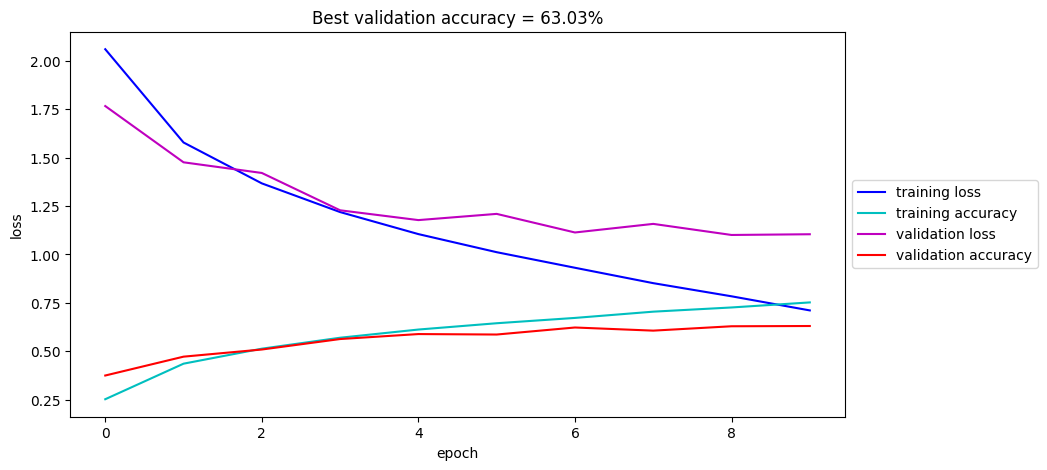

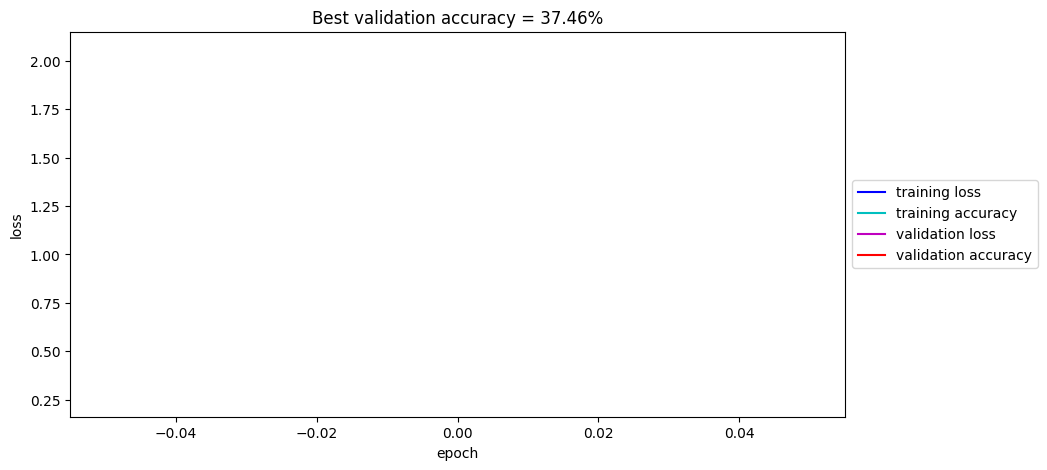

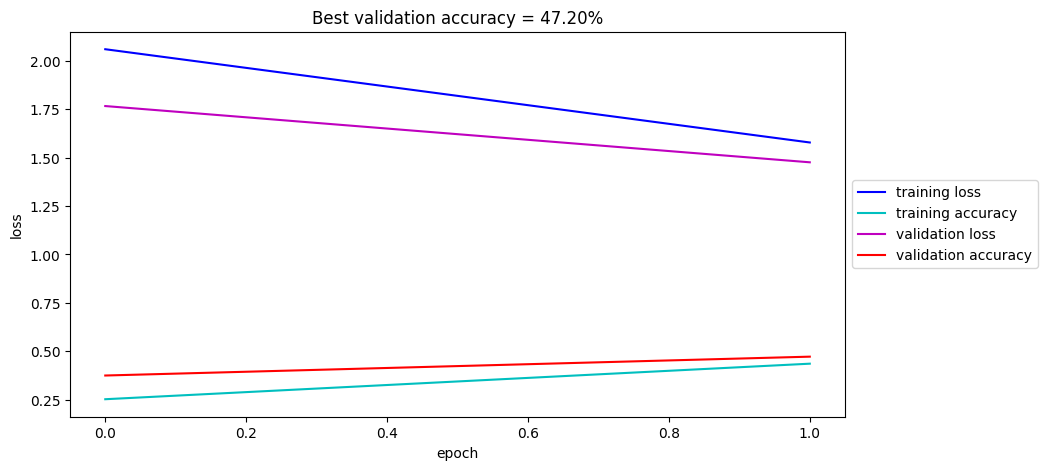

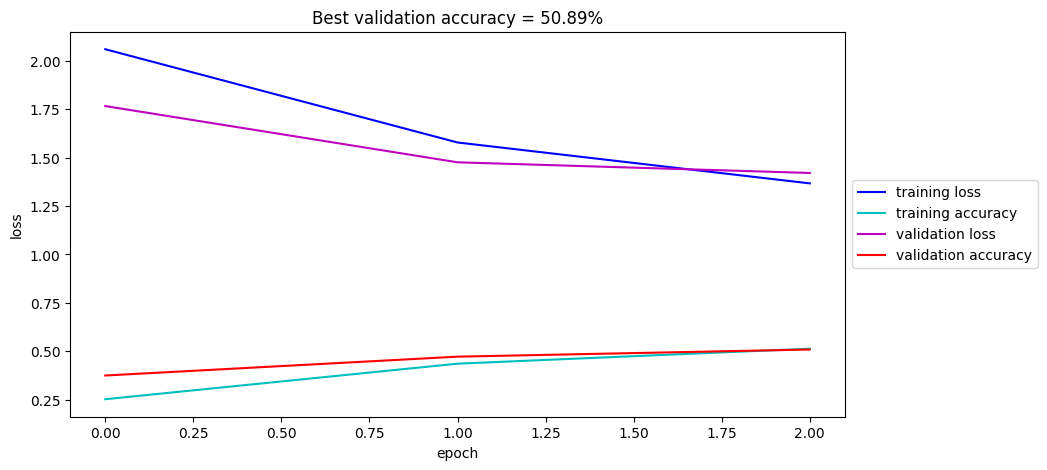

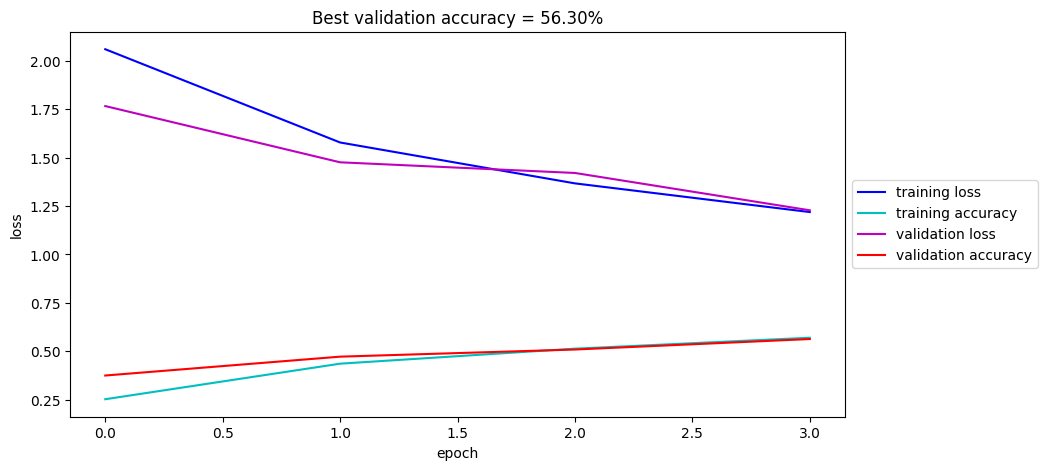

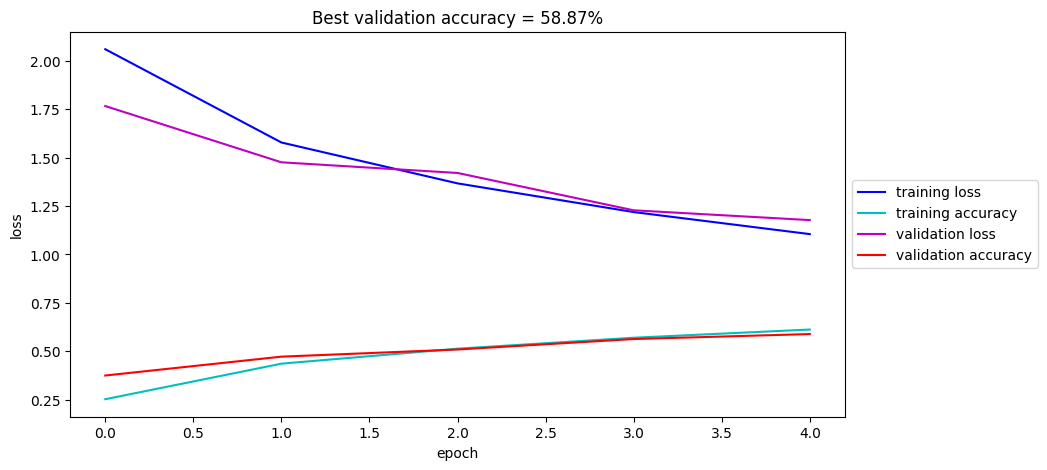

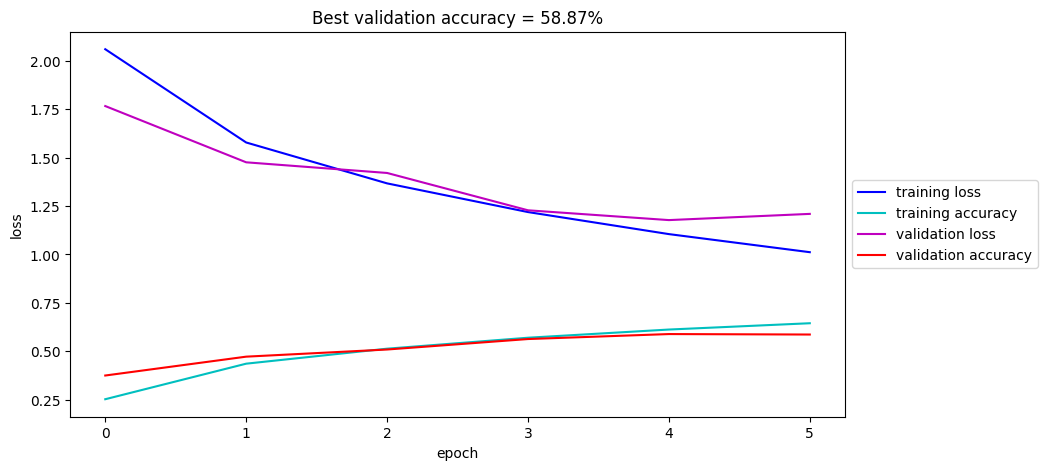

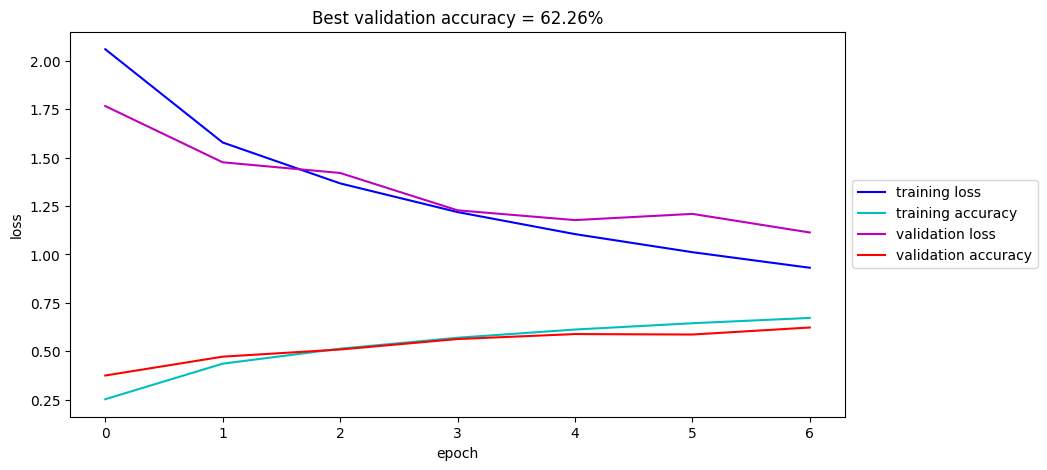

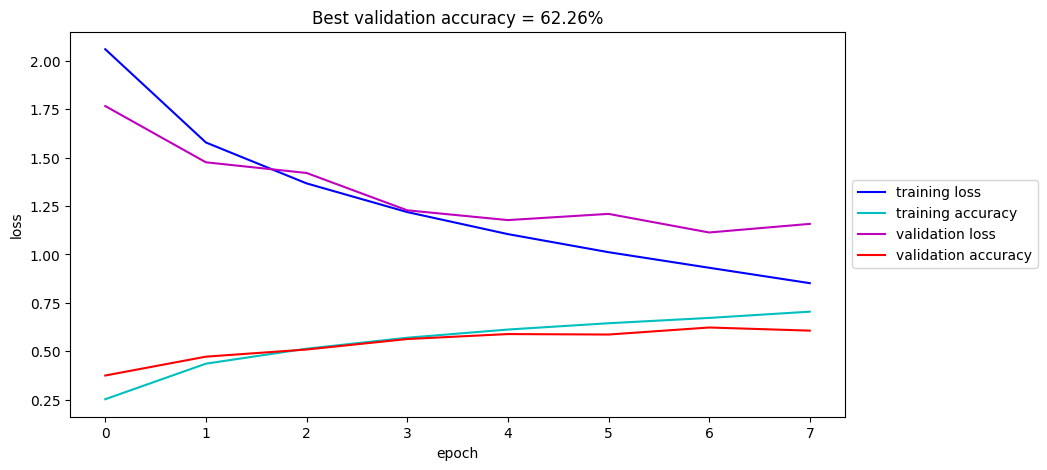

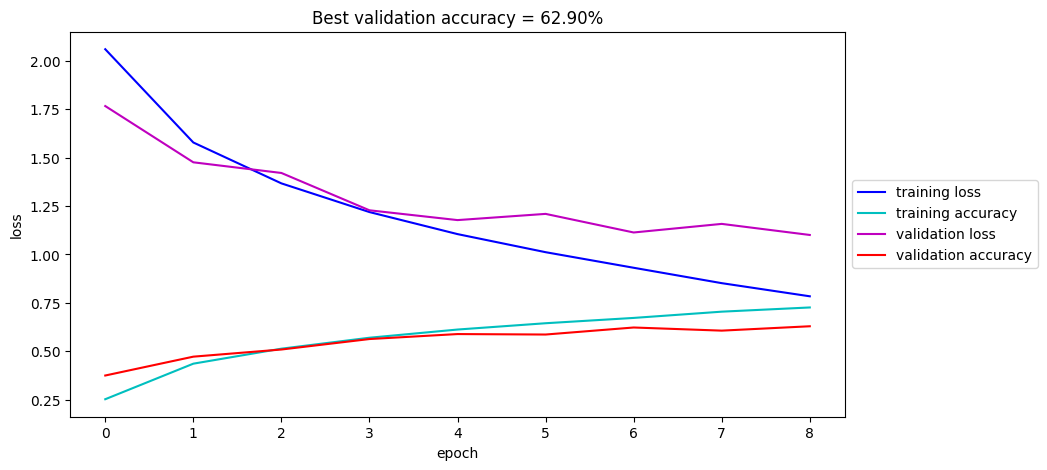

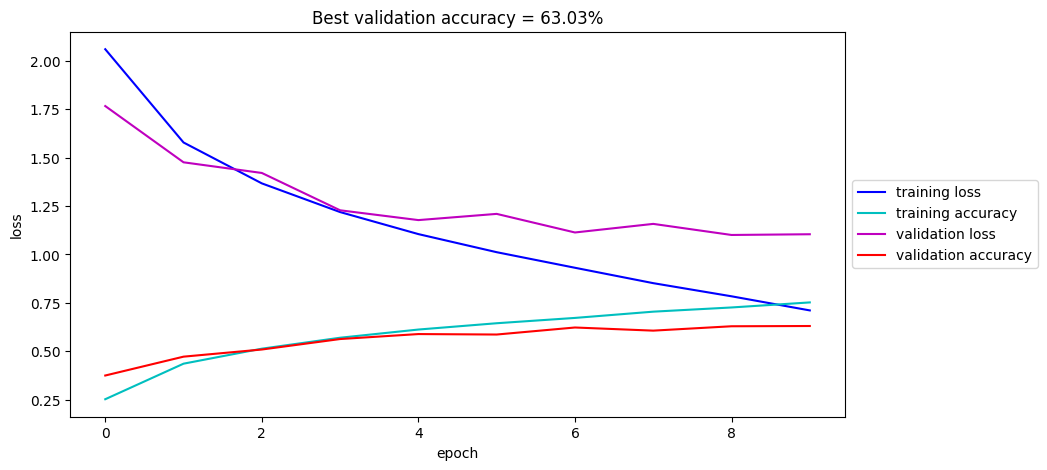

In [13]:
train_network(network, train_x, train_y_one_hot,
              val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [14]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_2'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


# Task 3: Add dropout layers
Modify your network and add dropout.

**Hint**: dropout is typically added to fully-connected layers, but it can be applied to convolutional layers as well.

In order to prepare and run your experiment, copy and modify previous cells to fill in the next three cells. Please do the same for the following tasks as well.

In [15]:
def build_neural_network_drop(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(inputs)
    network_2 = layers.MaxPool2D(pool_size=(2, 2))(network_1)
    network_3 = layers.Dropout(0.25)(network_2)

    network_4 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Flatten()(network_6)
    network_8 = layers.Dense(128, activation='relu')(network_7)
    network_9 = layers.Dropout(0.25)(network_8)

    prediction = layers.Dense(n_classes, activation='softmax')(network_9)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [16]:
# Compile the network, you can copy code from the first task.
network = build_neural_network_drop(data_size_in, n_classes)
network.compile(loss=ls, optimizer=sgd, metrics=metric)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,914 (1015.29 KB)

 Trainable params: 259,914 (1015.29 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_dropout.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

ValueError: Unknown variable: <Variable path=conv2d_2/kernel, shape=(5, 5, 3, 32), dtype=float32, value=[[[[-0.02575726  0.020856   -0.04403472 ... -0.01527896 -0.01885121
    -0.06043644]
   [-0.04390181 -0.03685578  0.04992029 ...  0.0658122  -0.02122456
     0.06083483]
   [-0.00049146 -0.01469944 -0.05486397 ...  0.05497974  0.05578311
     0.06746198]]

  [[-0.02324746 -0.06140286 -0.05781653 ...  0.01870457  0.00854273
    -0.01022755]
   [ 0.05134317  0.04137553  0.00185031 ... -0.03130568 -0.06417997
     0.05673738]
   [-0.01449297 -0.04542725 -0.00306651 ... -0.04973494 -0.0823048
    -0.0018434 ]]

  [[-0.07843196 -0.02461812  0.02349292 ... -0.00507227  0.00955846
    -0.04200576]
   [ 0.01526589  0.03365029  0.06838733 ... -0.01795342 -0.03265651
     0.06394961]
   [-0.08043426 -0.03443555  0.03256143 ... -0.02669997  0.0519504
    -0.07538119]]

  [[ 0.07827865 -0.08271334 -0.02988413 ... -0.05260386  0.03079233
     0.0236959 ]
   [ 0.00540794 -0.07234863 -0.0296895  ... -0.050664    0.01722964
     0.005836  ]
   [ 0.04273887 -0.02613256  0.04501639 ... -0.02505469  0.07136662
     0.0701277 ]]

  [[-0.0568495   0.03278861  0.02244102 ...  0.07040299 -0.03123283
     0.07493652]
   [ 0.04805894  0.04132303 -0.01138064 ... -0.07798105 -0.06539306
    -0.02978003]
   [ 0.06700383 -0.07671958 -0.03378241 ...  0.05170172 -0.00901172
     0.02798695]]]


 [[[ 0.00206456  0.02946663  0.01578611 ...  0.04248519  0.07549548
    -0.01461708]
   [-0.00948913 -0.02163498  0.03465422 ... -0.01009845  0.00080794
    -0.04888732]
   [ 0.05611442  0.08103704 -0.044211   ...  0.06543206  0.01681762
     0.04463421]]

  [[ 0.08277754  0.01797829 -0.04982672 ...  0.06038482 -0.03031328
     0.04859164]
   [ 0.02756408  0.01268277  0.04712172 ... -0.00335328  0.02198601
    -0.00909153]
   [ 0.06251718  0.01609938  0.06808142 ...  0.07060874 -0.01638762
     0.04343511]]

  [[-0.03851523 -0.06173748  0.05988061 ... -0.0291918  -0.07693607
    -0.00752211]
   [-0.07373343  0.03298892 -0.05641925 ...  0.02652933 -0.06282644
    -0.03605372]
   [-0.02873519 -0.08236144 -0.01022179 ... -0.04843522 -0.0521709
    -0.03729569]]

  [[ 0.06407553  0.0407111  -0.07498244 ...  0.03177664 -0.04877322
    -0.01920465]
   [-0.07343404  0.03057098  0.02276224 ...  0.01827181  0.05437846
     0.06558833]
   [ 0.01885618  0.05454083  0.01911218 ...  0.03295188 -0.07546073
    -0.05792123]]

  [[-0.07845303  0.04608901  0.04524569 ... -0.08066659 -0.01307187
    -0.01798749]
   [-0.08105259 -0.01984773  0.01486183 ...  0.06255411 -0.03452019
     0.03080786]
   [-0.04063801  0.00698663 -0.03615751 ...  0.0338674   0.05937317
    -0.05946919]]]


 [[[ 0.0459343  -0.03106235 -0.0128027  ...  0.01791282  0.02276696
    -0.0509086 ]
   [-0.02159046 -0.065249   -0.02854394 ...  0.04413541  0.0242151
    -0.04227835]
   [-0.05930132  0.07513481 -0.02181217 ... -0.03608669 -0.07870181
    -0.05580654]]

  [[ 0.03417861 -0.03804217  0.05788636 ...  0.08072734 -0.00102723
    -0.07165676]
   [ 0.00193364 -0.05677624  0.03792004 ... -0.00131508  0.01141685
     0.07462144]
   [ 0.00075043  0.05939484  0.06746036 ...  0.0041336   0.02417291
    -0.07269617]]

  [[ 0.06742017 -0.01418826 -0.08173186 ... -0.05885183  0.01158334
     0.02901339]
   [ 0.0792076  -0.0150144  -0.0225899  ...  0.02060913  0.04389174
    -0.00382916]
   [-0.03822244 -0.01293063  0.06717521 ... -0.05795604 -0.08221718
    -0.03883313]]

  [[-0.0636263   0.03367801  0.01628467 ...  0.02104196  0.00852481
     0.01639394]
   [ 0.01728425 -0.06181819 -0.02953504 ...  0.018971    0.05767553
    -0.01672446]
   [-0.04479926 -0.01999456  0.06407133 ... -0.00112698 -0.08032559
    -0.01048608]]

  [[-0.01443069  0.04489043  0.03202766 ... -0.07464257  0.05580907
     0.02373158]
   [-0.08257601  0.03465232  0.01048999 ...  0.00397593 -0.07826857
    -0.05057555]
   [ 0.06789108 -0.01555206  0.01377101 ...  0.02162564 -0.00458332
    -0.04258241]]]


 [[[ 0.03957933 -0.0363557   0.07890013 ... -0.04880925 -0.01489946
     0.06198573]
   [ 0.06829017 -0.0134078  -0.02151005 ... -0.01581828 -0.02238756
     0.05504933]
   [ 0.04096311 -0.04788631  0.06097703 ...  0.03149573 -0.04392676
     0.01442657]]

  [[-0.03249728 -0.00822501  0.05145098 ... -0.05818211 -0.06516748
    -0.02900936]
   [-0.00575189  0.04965468 -0.02984143 ...  0.04707789  0.03277309
    -0.0542981 ]
   [ 0.03327602  0.08003539  0.04000533 ... -0.00265019 -0.03630124
    -0.04156079]]

  [[-0.06949657  0.04313663  0.04668427 ...  0.05836186 -0.02231739
    -0.03494545]
   [ 0.04856582  0.02488028  0.03046732 ... -0.05477049  0.06640503
     0.06124009]
   [ 0.07802123 -0.07628686 -0.00913912 ... -0.04892222 -0.02388603
    -0.06976821]]

  [[-0.01506489  0.00050518  0.03617916 ... -0.01258139 -0.05222381
     0.03944577]
   [ 0.0203676   0.06977753 -0.01805055 ...  0.00359132  0.0005376
     0.07079352]
   [-0.00051282 -0.06438161  0.04017638 ... -0.05750175 -0.03162808
    -0.01794124]]

  [[ 0.06555602 -0.07952326 -0.03059563 ... -0.05837934 -0.01669182
    -0.03850072]
   [ 0.02813937 -0.01065706 -0.035161   ...  0.05761121  0.03515897
     0.07317954]
   [-0.02156695 -0.04134808  0.05963387 ... -0.02624519 -0.06276537
    -0.07734068]]]


 [[[ 0.00523227  0.04248632  0.06809451 ...  0.01701272  0.06891757
     0.03691705]
   [-0.0630665   0.04054271 -0.00751653 ...  0.05297932  0.04013083
    -0.05380972]
   [ 0.02851648  0.03834786 -0.00088839 ... -0.02551626 -0.00967366
    -0.0571874 ]]

  [[-0.05314062 -0.01947198  0.05310243 ...  0.04764609 -0.02718841
    -0.04339473]
   [-0.01156389 -0.06395538 -0.02805433 ...  0.04975249 -0.04110343
     0.01300268]
   [ 0.04816334 -0.02866099 -0.02252051 ... -0.04723884  0.03202932
     0.0453956 ]]

  [[ 0.04166993  0.03255049 -0.01002961 ...  0.01108108  0.00097124
    -0.04455901]
   [-0.01786264  0.0766542  -0.06325599 ... -0.05990577 -0.08224474
     0.07769348]
   [-0.0329525  -0.06863983 -0.0130173  ... -0.05540329  0.04984751
     0.05212952]]

  [[-0.0393759   0.08089627 -0.03375752 ...  0.06754786  0.05150194
    -0.01890469]
   [-0.00840449 -0.03946522  0.08036678 ... -0.02611887 -0.0513219
     0.02355757]
   [ 0.01291749  0.01987953  0.03644439 ... -0.04699498 -0.07739613
    -0.03990602]]

  [[ 0.01536074  0.07206206 -0.03580881 ...  0.06918836 -0.06526671
    -0.04826087]
   [-0.05588887 -0.05342361 -0.00989863 ...  0.05860876 -0.05802693
    -0.026751  ]
   [ 0.07568859  0.01885097  0.00878154 ...  0.01306657 -0.03105868
     0.02587707]]]]>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

## Question
The learning curves changed after adding dropout. How, and why?

*Your answer here.*

Before implementing the dropout layer, the validation loss starts to increase very early, while the training loss resumes to decline. This mismatch indicates that the network has begun to overfit. At this point, it is better to do something to prevent overfitting such as dropout. At each update of the training phase, the dropout layer tries setting the outgoing edges of hidden units (neurons that make up hidden layers) to zero. Thus, after adding these layers, the overfitting problem got almost improved as it can be seen the gap between training and validation loss curves has been removed and they are changing in the same pace.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_3'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 4: Add batch normalization
Add batch normalization to your network.

In [ ]:
def build_neural_network_batch_norm(data_size_in, n_classes):

    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.MaxPool2D(pool_size=(2, 2))(network_2)
    network_4 = layers.Dropout(0.25)(network_3)

    network_5 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_4)
    network_6 = layers.BatchNormalization()(network_5)
    network_7 = layers.MaxPool2D(pool_size=(2, 2))(network_6)
    network_8 = layers.Dropout(0.25)(network_7)

    network_9 = layers.Flatten()(network_8)
    network_10 = layers.Dropout(0.25)(network_9)
    network_11 = layers.Dense(128, activation='relu')(network_10)
    network_12 = layers.BatchNormalization()(network_11)
    network_13 = layers.Dropout(0.25)(network_12)
    prediction = layers.Dense(n_classes, activation='softmax')(network_13)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [ ]:
# Compile the network, you can copy code from the first task.
network = build_neural_network_batch_norm(data_size_in, n_classes)
network.compile(loss=ls, optimizer=sgd, metrics=metric)

In [ ]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_batchnorm.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)
network_name = 'network_task_4'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)
# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 5: Try different initialization strategies
Try different Weight initialization strategies in your network. Make a new cell for each different strategy and retrain your network every time. Please see https://www.tensorflow.org/api_docs/python/tf/keras/initializers for examples.

1. Xavier Glorot: http://proceedings.mlr.press/v9/glorot10a.html
2. He: https://arxiv.org/abs/1502.01852

In [ ]:
def build_neural_network_diff_init(data_size_in, n_classes):
    # Apparently, He is more compatible with relu and Glorot is more adjustable with tanh
    initializer = tf.keras.initializers.HeNormal()
    bias_init = tf.keras.initializers.zeros()

    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same',
                              kernel_initializer=initializer, bias_initializer=bias_init)(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.MaxPool2D(pool_size=(2, 2))(network_8)
    network_10 = layers.Dropout(0.25)(network_9)

    network_11 = layers.Flatten()(network_10)
    network_12 = layers.Dense(256, activation='relu',
                              kernel_initializer=initializer)(network_11)
    network_13 = layers.BatchNormalization()(network_12)
    network_14 = layers.Dropout(0.25)(network_13)
    network_15 = layers.Dense(128, activation='relu',
                              kernel_initializer=initializer)(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.Dropout(0.25)(network_16)

    prediction = layers.Dense(n_classes, activation='softmax')(network_17)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [ ]:
# Compile the network, you can copy code from the first task.

network = build_neural_network_diff_init(data_size_in, n_classes)
network.compile(loss=ls, optimizer=sgd, metrics=metric)

In [ ]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_init.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_5'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 6: Try different nonlinearities
Try different nonlinearities in your network. You can view supported activations functions in the Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/activations. If you want you can also try the advanced activations; these are implemented as layers.

In [ ]:
def build_neural_network_diff_nonlin(data_size_in, n_classes):

    initializer = tf.keras.initializers.HeUniform()
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu', padding='same',
                              kernel_initializer=initializer)(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(32, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.MaxPool2D(pool_size=(2, 2))(network_8)
    network_10 = layers.Dropout(0.25)(network_9)

    network_11 = layers.Flatten()(network_10)
    network_12 = layers.Dense(256, activation='gelu',
                              kernel_initializer=initializer)(network_11)
    network_13 = layers.BatchNormalization()(network_12)
    network_14 = layers.Dropout(0.25)(network_13)
    network_15 = layers.Dense(128, activation='gelu',
                              kernel_initializer=initializer)(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.Dropout(0.25)(network_16)

    prediction = layers.Dense(n_classes, activation='softmax')(network_17)


    model = Model(inputs=inputs, outputs=prediction)

    print(model.summary())

    return model


In [ ]:
# Compile the network, you can copy code from the first task.
network = build_neural_network_diff_nonlin(data_size_in, n_classes)
network.compile(loss=loss, optimizer=sgd, metrics=metrics)

In [ ]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_nonlin.h5')
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

## Question
Calculating the sigmoid function is computationally expensive. What is the other main weakness of the function?


*Your answer here.*

For a large positive or large negative number, the sigmoid's output saturates (the curve becomes parallel to the x-axis). As a result, the gradient in these areas is nearly zero. This local gradient is multiplied by the gradient of this gate's output during backpropagation. Consequently, if the local gradient is very small, the gradient will be killed and the network will not learn. Interestingly, This vanishing gradient problem would be solved by ReLU or other functions similar to ReLU like SeLU or GeLU.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_6'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 7: L2 normalization
Add L2 regularization to your loss calculation. You can find examples at https://www.tensorflow.org/api_docs/python/tf/keras/regularizers.

In [ ]:
#from keras import regularizers

def build_neural_network_l2(data_size_in, n_classes):

    initializer = tf.keras.initializers.HeUniform()

    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu', padding='same',
                              kernel_initializer=initializer)(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(32, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer)(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.MaxPool2D(pool_size=(2, 2))(network_8)
    network_10 = layers.Dropout(0.25)(network_9)

    network_11 = layers.Flatten()(network_10)
    network_12 = layers.Dense(256, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_11)
    network_13 = layers.BatchNormalization()(network_12)
    network_14 = layers.Dropout(0.25)(network_13)
    network_15 = layers.Dense(128, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.Dropout(0.25)(network_16)

    prediction = layers.Dense(n_classes, activation='softmax')(network_17)


    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model


In [ ]:
# Compile the network, you can copy code from the first task.

network = build_neural_network_l2(data_size_in, n_classes)
network.compile(loss=loss, optimizer=sgd, metrics=metrics)

In [ ]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_l2.h5')

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

## Question
Is it necessary to monitor the L2 loss during training? Why?

*Your answer here.*

No, it would not need to monitor the changes of L2 loss function. As we know, regularizations are techniques for reducing error and avoiding overfitting by fitting a function appropriately on the given training set. L2 as a regularization term is a coefficient ($\lambda$) by the quadratic norm of weights that permanently tries to control the value of parameters to avoid getting large. Thus, L2 adjusts itself with the main term of the loss function. Then, these two terms should modify at the same time. Consequently, it seems individually monitoring of L2 loss could not be helpful in this case.

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_7'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 8: Add data augmentation

In this task you will have to implement different data augmentation techniques. We have created a simple framework to help you with this. You will have to implement at least three functions that augment an image using some method. Think about the task and images, and decide which augmentations could help the network to generalize.

You are free to use data augmentation libraries/frameworks (for example https://pillow.readthedocs.io). Feel free to change the augmentation framework below if you have any other ideas to augment the data or want to use an additional framework. Make sure to document which external software packages you use (if any).

In [ ]:
# Create (at least) three functions that take an image as input and return an augmented image
# Please give them sensible names, describing the augmentation.
# from PIL import Image, ImageFilter
def augmentation_rotation(image):

    image = np.array(image)
    image *= 255
    image = image.astype(dtype=np.uint8)
    pillow_image = Image.fromarray(image)
    rotated = pillow_image.rotate(15)
    image = np.array(rotated)
    image = image.astype(dtype=np.float32)
    image /= 255.
    return image

def augmentation_flip_leftright(image):

    image = np.array(image)
    image *= 255
    image = image.astype(dtype=np.uint8)
    pillow_image = Image.fromarray(image)
    Fliped = pillow_image.transpose(Image.FLIP_LEFT_RIGHT)
    image = np.array(Fliped)
    image = image.astype(dtype=np.float32)
    image /= 255.
    return image

def augmentation_zoom(image):
    image = np.array(image)
    image *= 255
    image = image.astype(dtype=np.uint8)
    pillow_image = Image.fromarray(image)
    x, y, zoom = 16, 16, 1.3
    w, h = 32, 32
    zoom2 = zoom * 2
    zoomed = pillow_image.crop((x - w / zoom2, y - h / zoom2,
                    x + w / zoom2, y + h / zoom2))

    zoomed = zoomed.resize((w, h), Image.LANCZOS)
    image = np.array(zoomed)
    image = image.astype(dtype=np.float32)
    image /= 255.
    return image

# Fill this array with your augmentation functions
augmentations = [augmentation_rotation, augmentation_flip_leftright, augmentation_zoom]

# Preview your augmentations on an image
test_image = train_x[1].copy()
fig, axarr = plt.subplots(ncols=len(augmentations) + 1, nrows=1)
axarr[0].imshow((test_image))
for key, augment_func in enumerate(augmentations):
    axarr[key + 1].imshow(augment_func(test_image))
plt.show()

The function below takes the original data as input and returns an augmented dataset.

In [ ]:
# Function to augment data
# The ratio defines how many of the images will be augmented.
def augment_data(original_data, ratio=0.4):

    data = original_data.copy()

    # Apply augmentations on a random portion of the data
    for augment_func in augmentations:
        indices = np.random.choice(len(data), int(len(data) * ratio))

        for i in indices:
            data[i] = augment_func(data[i])

    return data

Our train function needs to be adapted to work with the augmentations. Think about how you can do this.

In [ ]:
def pre_processing_AUG(x_training, y_training):
    y_training_2 = np.argmax(y_training, axis=1)

    x_training_aug = x_training.copy()
    y_training_aug = y_training_2.copy()

    for i in range(10):
      new_data = augment_data(x_training[y_training_2 == i])
      # new_data = np.array(new_data)
      x_training_aug = np.concatenate((x_training_aug, new_data))
      new_data_label = np.ones((len(new_data))) * i
      y_training_aug = np.concatenate((y_training_aug, new_data_label))

    x_training = x_training_aug
    y_training = tf.keras.utils.to_categorical(y_training_aug, num_classes=n_classes, dtype='float32')
    return x_training, y_training

def train_network_with_augmentations(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    x_training, y_training = pre_processing_AUG(x_training, y_training)

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit(x_training, y_training, batch_size=batch_size)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x=x_validation, y=y_validation, batch_size=1)
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [ ]:
network_filepath = os.path.join(file_dir, 'best_model_net_augmentations.h5')

train_network_with_augmentations(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_8'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

#### Question
Should the upside-down flipping be used as augmentation? Why?

*Your answer here.*

No, since data augmentation should make sense for new data. In this specific dataset (CIFAR10), as all images are real-world examples and we can not see any of them in a head-to situation, we should not train our model with 180-degree-rotated pictures then evaluate our model with the regular test set.

# Task 9: Try different architectures

The architectures we used so far were pretty simple. Try to build a different (deeper) architecture and see how it performs.

In [ ]:
def build_neural_network_deep_arch(data_size_in, n_classes):

    initializer = tf.keras.initializers.HeUniform()
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(64, kernel_size=(3, 3), activation='selu',
                              kernel_initializer=initializer, padding='same')(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.Conv2D(64, kernel_size=(3, 3), activation='selu',
                              kernel_initializer=initializer, padding='same')(network_2)
    network_4 = layers.BatchNormalization()(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer, padding='same')(network_6)
    network_8 = layers.BatchNormalization()(network_7)
    network_9 = layers.Conv2D(64, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer, padding='same')(network_8)
    network_10 = layers.BatchNormalization()(network_9)
    network_11 = layers.MaxPool2D(pool_size=(2, 2))(network_10)
    network_12 = layers.Dropout(0.25)(network_11)

    network_13 = layers.Conv2D(128, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_12)
    network_14 = layers.BatchNormalization()(network_13)
    network_15 = layers.Conv2D(128, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_14)
    network_16 = layers.BatchNormalization()(network_15)
    network_17 = layers.MaxPool2D(pool_size=(2, 2))(network_16)
    network_18 = layers.Dropout(0.25)(network_17)

    network_19 = layers.Conv2D(128, kernel_size=(5, 5), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_18)
    network_20 = layers.BatchNormalization()(network_19)
    network_21= layers.Conv2D(128, kernel_size=(5, 5), activation='gelu',
                              kernel_initializer=initializer, padding='same')(network_20)
    network_22 = layers.BatchNormalization()(network_21)
    network_23 = layers.MaxPool2D(pool_size=(2, 2))(network_22)
    network_24 = layers.Dropout(0.25)(network_23)

    network_25 = layers.Conv2D(256, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_24)
    network_26 = layers.BatchNormalization()(network_25)
    network_27 = layers.Conv2D(256, kernel_size=(3, 3), activation='gelu',
                               kernel_initializer=initializer, padding='same')(network_26)
    network_28 = layers.BatchNormalization()(network_27)
    network_29 = layers.MaxPool2D(pool_size=(2, 2))(network_28)
    network_30 = layers.Dropout(0.25)(network_29)

    network_31 = layers.Flatten()(network_30)

    network_32 = layers.Dense(512, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_31)
    network_33 = layers.BatchNormalization()(network_32)
    network_34 = layers.Dropout(0.25)(network_33)

    network_35 = layers.Dense(1024, activation='gelu', kernel_initializer=initializer,
                              kernel_regularizer=regularizers.l2(1e-5))(network_34)
    network_36 = layers.BatchNormalization()(network_35)
    network_37 = layers.Dropout(0.25)(network_36)

    prediction = layers.Dense(n_classes, activation='softmax')(network_37)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

In [ ]:
# Compile the network, you can copy code from the first task.

network = build_neural_network_deep_arch(data_size_in, n_classes)
network.compile(loss=loss, optimizer=sgd, metrics=metrics)

In [ ]:
# train and validate the network
network_filepath = os.path.join(file_dir, 'best_model_net_deep.h5')
# first augmenting data
train_x, train_y_one_hot = pre_processing_AUG(train_x, train_y_one_hot)

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [ ]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function
best_network=keras.models.load_model(network_filepath)

network_name = 'network_task_9'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open('./results_{}.csv'.format(network_name), 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write('{}, {}\n'.format(filename, label))
ho.close()

# Task 10: Tools to monitor training procedure

You can think of different statistics that you could monitor to get a better understanding of how well the model is training. Such techniques could guide you to improve your model in a number of ways. some ideas:

1. Monitor the norm of the weights of the network during training: and see if your l2-regularization mitigates issues of overfitting by reducing this norm. What happends if you don't use l2-regularization, will this norm increase over time (after several epochs) and is it connected to overfitting in any way?
2. Monitor the norm of the gradient (the average of all nodes/layers, or per node/layer) during training to see if the network is actually learning from some gradient signal: and how this changes over time (over several epochs).
3. Visualize some of the filters of your CNN (sometimes referred to as kernels) and compare them (visually) before training (at random initialisation) and after training. You could do so for (only) the first layer of your network, or for multiple layers. Do they look like you had expected?

Implement one of these ideas (or come up with some other statistic/method) and visualize the result. Describe in one or two sentences what you see and if this is what you were expecting to see.

In [ ]:
from cv2 import resize
from matplotlib import pyplot
from tensorflow.keras.applications.vgg16 import preprocess_input
%matplotlib inline

In [ ]:
model = build_neural_network(data_size_in, n_classes)
model.compile(loss=loss, optimizer=sgd, metrics=metrics)

In [ ]:
for layer in model.layers:
# check for convolutional layer
    if 'conv' not in layer.name:
        continue
# get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
# plot first few filters

n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure

pyplot.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from skimage.measure import block_reduce
import cv2


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import expand_dims

model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img('/content/sample_data/bird.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
    # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()